In [1]:
%matplotlib inline


# Training a Classifier
前文学习，已经知道了模型定义，计算loss与更新权证，接下来，学习如何训练一个模型。


# What about data?


通常来说，当必须处理图像、文本、音频或视频数据时，可以使用python标准库将数据加载到numpy数组里。然后将这个数组转化成torch.*Tensor。

- 对于图片，有Pillow，OpenCV等包可以使用
- 对于音频，有scipy和librosa等包可以使用
- 对于文本，不管是原生python的或者是基于Cython的文本，可以使用NLTK和SpaCy

视觉方面，PytTorch开发了一个包：``torchvision``，其中包含了针对Imagenet、CIFAR10、MNIST等常用数据集的数据加载器(data loaders），还有对图像数据转换的操作，即`torchvision.datasets`和`torch.utils.data.DataLoader`。

以下部分，我们使用CIFAR10数据集，它有如下的分类：“飞机”，“汽车”，“鸟”，“猫”，“鹿”，“狗”，“青蛙”，“马”，“船”，“卡车”等。在CIFAR-10里面的图片数据大小是3x32x32，即：三通道彩色图像，图像大小是32x32像素。
![cifar10](./assets/cifar10.png)


# Training an image classifier


我们将按顺序做以下步骤：

1. 通过torchvision加载CIFAR10里面的训练和测试数据集，并对数据进行标准化
2. 定义卷积神经网络
3. 定义损失函数
4. 利用训练数据训练网络
5. 利用测试数据测试网络

## Loading and normalizing CIFAR10

使用``torchvision``加载CIFAR10.



In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision数据集加载完后的输出是范围在$[0, 1]$之间的PILImage。我们将其标准化为范围在$[-1, 1]$之间的张量。

tips:
> If running on Windows and you get a BrokenPipeError, try setting
the num_worker of torch.utils.data.DataLoader() to 0.

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='../../../../learnMLData/data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../../../../learnMLData/data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


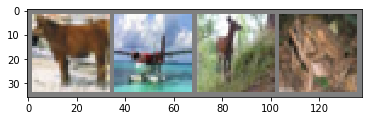

horse plane  deer  frog


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Define a Convolutional Neural Network

将之前神经网络章节定义的神经网络拿过来，并将其修改成输入为3通道图像(替代原来定义的单通道图像,也就是`self.conv1`参数）。



In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

##  Define a Loss function and optimizer

我们使用多分类的交叉熵损失函数和随机梯度下降优化器(使用momentum）


In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the network

定义了epoch，然后遍历数据迭代器（数据load时，做了shuffle，batch）



In [12]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.162
[1,  4000] loss: 1.845
[1,  6000] loss: 1.685
[1,  8000] loss: 1.557
[1, 10000] loss: 1.485
[1, 12000] loss: 1.446
[2,  2000] loss: 1.355
[2,  4000] loss: 1.348
[2,  6000] loss: 1.318
[2,  8000] loss: 1.281
[2, 10000] loss: 1.262
[2, 12000] loss: 1.250
Finished Training


### 保存模型
[保存模型](https://pytorch.org/docs/stable/notes/serialization.html)


In [7]:
PATH = '../../../../learnMLData/cifar_net.pth'
torch.save(net.state_dict(), PATH)

## 使用测试数据测试网络

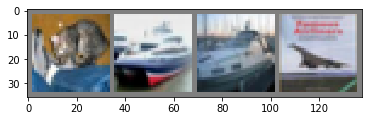

GroundTruth:    cat  ship  ship plane


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [10]:
# 重新加载模型
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [13]:
# 网络输出
outputs = net(images)

# 预测结果
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


整个数据集表现


In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


这比随机选取(即从10个类中随机选择一个类，正确率是10%）要好很多。看来网络确实学到了一些东西。

那么哪些是表现好的类呢？哪些是表现的差的类呢？


In [15]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 44 %
Accuracy of   car : 74 %
Accuracy of  bird : 37 %
Accuracy of   cat : 49 %
Accuracy of  deer : 63 %
Accuracy of   dog : 20 %
Accuracy of  frog : 68 %
Accuracy of horse : 62 %
Accuracy of  ship : 77 %
Accuracy of truck : 64 %




## Training on GPU

与将一个张量传递给GPU一样，可以这样将神经网络转移到GPU上。

如果我们有cuda可用的话，让我们首先定义第一个设备为可见cuda设备：


In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


本节的其余部分假设device是CUDA。

然后这些方法将递归遍历所有模块，并将它们的参数和缓冲区转换为CUDA张量：

In [19]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

为什么我们感受不到与CPU相比的巨大加速？因为我们的网络实在是太小了。

尝试一下：加宽你的网络(注意第一个nn.Conv2d的第二个参数和第二个nn.Conv2d的第一个参数要相同），看看能获得多少加速。

已实现的目标：

在更高层次上理解PyTorch的Tensor库和神经网络
训练一个小的神经网络做图片分类
在多GPU上训练
如果希望使用您所有GPU获得更大的加速，请查看[Optional: Data Parallelism](https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html)

In [18]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.152
[1,  4000] loss: 1.127
[1,  6000] loss: 1.143
[1,  8000] loss: 1.149
[1, 10000] loss: 1.137
[1, 12000] loss: 1.132
[2,  2000] loss: 1.126
[2,  4000] loss: 1.146
[2,  6000] loss: 1.147
[2,  8000] loss: 1.152
[2, 10000] loss: 1.139
[2, 12000] loss: 1.124
Finished Training
